In [1]:
%load_ext autoreload
%autoreload 2

import logging
from pathlib import Path

import awkward as ak
import numpy as np
import vector
from omegaconf import OmegaConf

import gabbro.plotting.utils as plot_utils
from gabbro.plotting.feature_plotting import plot_features
from gabbro.utils.arrays import ak_select_and_preprocess

# hacky way to setup logging in jupyter
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.info("Setup complete")

vector.register_awkward()

INFO:root:Setup complete


# Tokenization with the VQ-VAE

This notebook provides a short example on how to

- load a trained VQ-VAE model that was trained with this repo
- use the model to encode/tokenize jets from the JetClass dataset
- reconstruct/decode the jets from the tokens

In [2]:
# --- Load the tokenizer model from checkpoint, and also get the feature_dict from the config ---

from gabbro.models.vqvae import VQVAELightning

# this checkpoint is the checkpoint from a tokenization training
ckpt_path = "../../checkpoints/vqvae_8192_tokens/model_ckpt.ckpt"
vqvae_model = VQVAELightning.load_from_checkpoint(ckpt_path)
vqvae_model.eval()

cfg = OmegaConf.load(Path(ckpt_path).parent / "config.yaml")
pp_dict = OmegaConf.to_container(cfg.data.dataset_kwargs_common.feature_dict)
print("\npp_dict:")
for item in pp_dict:
    print(item, pp_dict[item])

# get the cuts from the pp_dict (since this leads to particles being removed during
# preprocessing/tokenization), thus we also have to remove them from the original jets
# when we compare the tokenized+reconstructed particles to the original ones)
pp_dict_cuts = {
    feat_name: {
        criterion: pp_dict[feat_name].get(criterion)
        for criterion in ["larger_than", "smaller_than"]
    }
    for feat_name in pp_dict
}

print("\npp_dict_cuts:")
for item in pp_dict_cuts:
    print(item, pp_dict_cuts[item])

print("\nModel:")
print(vqvae_model)


pp_dict:
part_pt {'multiply_by': 1, 'subtract_by': 1.8, 'func': 'np.log', 'inv_func': 'np.exp'}
part_etarel {'multiply_by': 3, 'larger_than': -0.8, 'smaller_than': 0.8}
part_phirel {'multiply_by': 3, 'larger_than': -0.8, 'smaller_than': 0.8}

pp_dict_cuts:
part_pt {'larger_than': None, 'smaller_than': None}
part_etarel {'larger_than': -0.8, 'smaller_than': 0.8}
part_phirel {'larger_than': -0.8, 'smaller_than': 0.8}

Model:
VQVAELightning(
  (model): VQVAENormFormer(
    (input_projection): Linear(in_features=3, out_features=128, bias=True)
    (encoder_normformer): NormformerStack(
      (blocks): ModuleList(
        (0-3): 4 x NormformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): La

### Load a file from the JetClass dataset

In [3]:
from gabbro.data.loading import read_jetclass_file

jetclass_file_path = (
    "/beegfs/desy/user/birkjosc/datasets/jetclass/JetClass/test_20M/ZJetsToNuNu_100.root"
)

part_features_ak, _, _ = read_jetclass_file(
    filepath=jetclass_file_path,
    particle_features=["part_pt", "part_etarel", "part_phirel"],
    jet_features=None,
    labels=None,
    n_load=100_000,
)
part_features_ak = ak_select_and_preprocess(part_features_ak, pp_dict_cuts)[:, :128]

### Tokenize and reconstruct the jets

In [4]:
# tokenization and reconstruction

part_features_ak_tokenized = vqvae_model.tokenize_ak_array(
    ak_arr=part_features_ak,
    pp_dict=pp_dict,
    batch_size=512,
    pad_length=128,
)
# note that if you want to reconstruct tokens from the generative model, you'll have
# to remove the start token from the tokenized array, and subtract 1 from the tokens
# (since we chose the convention to use 0 as the start token, so the tokens from the
# generative model are shifted by 1 compared to the ones from the VQ-VAE)
part_features_ak_reco = vqvae_model.reconstruct_ak_tokens(
    tokens_ak=part_features_ak_tokenized,
    pp_dict=pp_dict,
    batch_size=512,
    pad_length=128,
)

100%|██████████| 196/196 [00:04<00:00, 48.80it/s]


In [5]:
# inspect the tokenized and reconstructed jets
print("First 5 tokenized jets:")
for i in range(5):
    print(part_features_ak_tokenized[i])

print("\nFirst 5 reconstructed jets:")
for i in range(5):
    print(part_features_ak_reco[i])

First 5 tokenized jets:
[500, 4.81e+03, 803, 4.9e+03, 2.84e+03, ..., 5.75e+03, 4.82e+03, 5.9e+03, 683]
[7.24e+03, 5.92e+03, 4.74e+03, 3.4e+03, ..., 2.77e+03, 2.77e+03, 3.01e+03]
[4.6e+03, 1.58e+03, 489, 1.27e+03, ..., 1.13e+03, 4.49e+03, 5.36e+03, 2.26e+03]
[6.29e+03, 6.13e+03, 3.86e+03, 3.19e+03, 7.91e+03, ..., 157, 978, 63, 1.49e+03]
[97, 2.4e+03, 5.34e+03, 7.32e+03, ..., 6.72e+03, 3.53e+03, 4.81e+03, 6.13e+03]

First 5 reconstructed jets:
{part_pt: [143, 120, ..., 0.613, 0.493], part_etarel: [...], ...}
{part_pt: [111, 59.2, ..., 0.943, 0.957], part_etarel: [...], ...}
{part_pt: [117, 81.2, ..., 0.982, 0.668], part_etarel: [...], ...}
{part_pt: [62.6, 56.4, ..., 2.26, 1.19], part_etarel: [...], ...}
{part_pt: [65.7, 53.1, ..., 0.851, 0.802], part_etarel: [...], ...}


### Calculate the four-momentum of the reconstructed jets and make comparison plots

In [6]:
def get_p4s_from_part_features(part_features):
    """Small helper function to get the 4-momentum from part_features."""
    return ak.zip(
        {
            "pt": part_features.part_pt,
            "eta": part_features.part_etarel,
            "phi": part_features.part_phirel,
            "mass": ak.zeros_like(part_features.part_pt),  # massless particles
        },
        with_name="Momentum4D",
    )


p4s_original = get_p4s_from_part_features(part_features_ak)
p4s_reco = get_p4s_from_part_features(part_features_ak_reco)

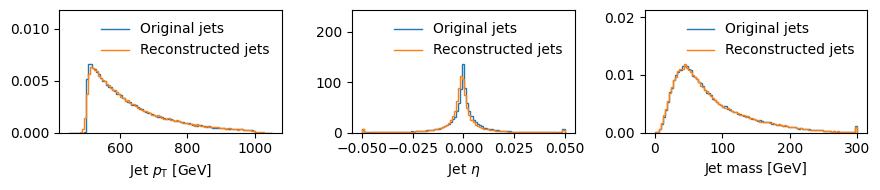

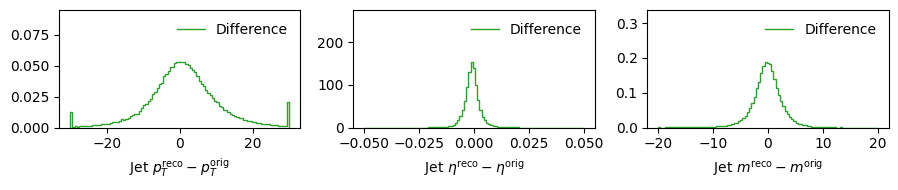

In [7]:
# plot inclusive jet-level distributions
p4s_jets_original = ak.sum(p4s_original, axis=1)
p4s_jets_reco = ak.sum(p4s_reco, axis=1)

fig, axarr = plot_features(
    ak_array_dict={
        "Original jets": p4s_jets_original,
        "Reconstructed jets": p4s_jets_reco,
    },
    names={
        "pt": plot_utils.DEFAULT_LABELS["jet_pt"],
        "eta": plot_utils.DEFAULT_LABELS["jet_eta"],
        # "phi": plot_utils.DEFAULT_LABELS["jet_phi"],
        "mass": plot_utils.DEFAULT_LABELS["jet_mass"],
    },
    flatten=False,
    decorate_ax_kwargs={"yscale": 1.7},
    bins_dict={
        "pt": np.linspace(450, 1050, 100),
        "eta": np.linspace(-0.05, 0.05, 100),
        "mass": np.linspace(0, 300, 100),
    },
)
# plot the resolution (i.e. jet features of the reconstructed jets - jet features of the original jets)
fig, axarr = plot_features(
    ak_array_dict={
        "Difference": ak.Array(
            {
                "pt": p4s_jets_reco.pt - p4s_jets_original.pt,
                "eta": p4s_jets_reco.eta - p4s_jets_original.eta,
                "mass": p4s_jets_reco.mass - p4s_jets_original.mass,
            }
        )
    },
    names={
        "pt": "Jet $p_T^{\\text{reco}} - p_T^{\\text{orig}}$",
        "eta": "Jet $\\eta^{\\text{reco}} - \\eta^{\\text{orig}}$",
        "mass": "Jet $m^{\\text{reco}} - m^{\\text{orig}}$",
    },
    flatten=False,
    decorate_ax_kwargs={"yscale": 1.7},
    bins_dict={
        "pt": np.linspace(-30, 30, 100),
        "eta": np.linspace(-0.05, 0.05, 100),
        "mass": np.linspace(-20, 20, 100),
    },
    colors=["C2"],
)